In [12]:
import torch
from tqdm.autonotebook import tqdm, trange

In [149]:
# number of points
n_points = 5

# estimate maximum coordinate of point
n_estimate_max = 50

# distance between points as (i, j): d where i and j are the two points
distances = {
    (0, 1): 10,
    (1, 2): 10,
    (2, 3): 10,
    (3, 4): 10,
    (4, 0): 10,
    
    # diagonals
    (0, 2): 1.61803398875 * 10,
    (1, 3): 1.61803398875 * 10,
    (2, 4): 1.61803398875 * 10,
    (3, 0): 1.61803398875 * 10,
    (4, 1): 1.61803398875 * 10
}

# number of iterations
n_iterations = 5000

In [150]:
# create tensor of points
x = torch.rand(n_points, 2) * n_estimate_max
x = x.requires_grad_(True)

# create the target tensor
target = torch.tensor(list(distances.values()), dtype=torch.float)

def loss_fn(x):
    d = torch.sqrt(torch.sum(torch.pow(x[list(distances.keys()), :].diff(axis=1), 2), axis=-1)).squeeze()
    return d, torch.nn.functional.mse_loss(d, target)

optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.9)

# optimization loop
tq = trange(n_iterations)
for _ in tq:
    optimizer.zero_grad()
    d, loss = loss_fn(x)
    
    tq.set_postfix({"loss": loss.detach().numpy(), "distances": d.detach().numpy()})
    
    loss.backward()
    optimizer.step()
    
print(x)

  0%|          | 0/5000 [00:00<?, ?it/s]

tensor([[31.7819,  7.8917],
        [35.7866, 17.0548],
        [28.3096, 23.6951],
        [19.6838, 18.6359],
        [21.8298,  8.8689]], requires_grad=True)


0 1 9.999988555908203 10
1 2 9.99996566772461 10
2 3 9.99998664855957 10
3 4 9.999998092651367 10
4 0 10.000020980834961 10
0 2 16.18033218383789 16.1803398875
1 3 16.1803035736084 16.1803398875
2 4 16.180330276489258 16.1803398875
3 0 16.180347442626953 16.1803398875
4 1 16.180320739746094 16.1803398875


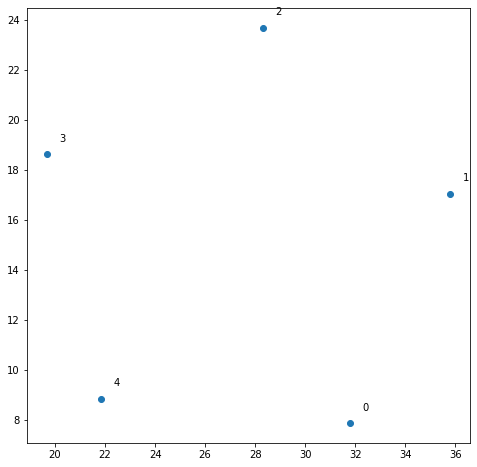

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

for (i, j), d in distances.items():
    print(i, j, torch.nn.functional.pdist(x[[i, j], :]).item(), d)

xv = x.detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect('equal', 'box')
ax.scatter(xv[:, 0], xv[:, 1])

for i in range(n_points):
    ax.annotate(str(i), (xv[i, 0].item() + 0.5, xv[i, 1].item() + 0.5))